# Bioinformatics software

## PubMed API Entrez Interactions

In [390]:
from datetime import datetime
import json
import re
import time

import dotenv
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm
import requests
import warnings
import xmltodict


%reload_ext autoreload
%autoreload 2
import pbmd_tools as pbmd

#### Using Esearch to get the list of IDs of the articles containing "github.com" in their abstract

In [381]:
API_KEY = pbmd.read_tokens()[0]
db = "pubmed"
domain = "https://www.ncbi.nlm.nih.gov/entrez/eutils"
nresults = 15000
retmode = "json"
queries = []
for i in range(2009,2024):
    queries.append(f'((github.com[Title/Abstract])) AND (("{i}/01/01"[Date - Publication] : "{i}/12/31"[Date - Publication]))')

Found GitHub token.
Found PubMed token.


In [363]:
PMIDs = []
stats = {}
for query in tqdm(queries):
    nb = 0
    queryLinkSearch = f"{domain}/esearch.fcgi?db={db}&retmax={nresults}&retmode={retmode}&term={query}&api_key={API_KEY}"
    response = requests.get(queryLinkSearch)
    pubmedJson = response.json()
    for id in pubmedJson["esearchresult"]["idlist"]:
        nb += 1
        PMIDs.append(id)
    stats[query[38:42]] = nb
PMIDs = set(PMIDs)

100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:14<00:00,  1.04it/s]


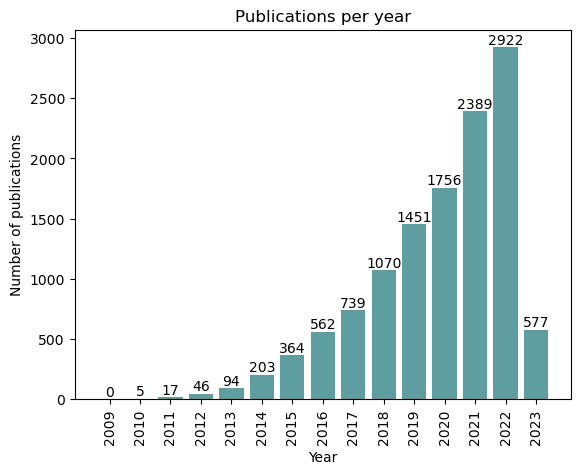

In [364]:
years = list(stats.keys())
values = list(stats.values())

plt.bar(years, values, color='cadetblue')

plt.xlabel('Year')
plt.ylabel('Number of publications')
plt.title('Publications per year')

for i, value in enumerate(values):
    plt.text(i, value, str(value), ha='center', va='bottom')

plt.xticks(rotation=90)

plt.show()

In [365]:
with open("PMIDs.txt", "w") as f:
    for PMID in PMIDs:
        f.write(str(PMID)+"\n")

In [ ]:
# https://pubmed.ncbi.nlm.nih.gov/26262258/ - No DOI in PubMed although there is one in the full text of the article (not from ArXiv), and there are a lot of them
# https://pubmed.ncbi.nlm.nih.gov/28269829/ - they give a wrong link https://github.com/SBU-BMI/imageboxs://github.com/SBU-BMI/imagebox but if you use this link :
# https://github.com/SBU-BMI/imagebox it works. Yet, i am not sure that it is actually what we are looking for since the also provide another link to github.io 
# (also incorect) and i think it's more likely that their code is there

#### Using Efetch to get all the necessary information about these articles

In [ ]:
#100%|██████████████████████████████████████████████████████████████████████████| 14072/14072 [2:31:15<00:00,  1.55it/s]

results = []
log_error_sum = []
for PMID in tqdm(PMIDs):
        results.append(pbmd.get_summary(PMID, log_error_sum)[:-1])

In [205]:
df1 = pd.DataFrame.from_records(results)
df1 = df1.rename(columns={0: 'PubDate', 1: 'DOI', 2: 'Journal', 3: 'Title', 4: 'Abstract'})
new_column = pd.read_csv('PMIDs.txt', header=None, names=['PMID'], lineterminator='\n')
df1.insert(loc=0, column='PMID', value=new_column)

df1[df1.isnull().any(axis=1)]

,PMID,PubDate,DOI,Journal,Title,Abstract
243,26713261,None,None,None,None,None
276,26262258,2015,None,Studies in health technology and informatics,Computationally Comparing and Analyzing All Pu...,The clinical literature presents four differen...
312,26958216,2015-11-05,None,AMIA ... Annual Symposium proceedings. AMIA Sy...,Reproducing a Prospective Clinical Study as a ...,"In this paper we sought to reproduce, as a com..."
313,26958160,2015-11-05,None,AMIA ... Annual Symposium proceedings. AMIA Sy...,OpenHealth Platform for Interactive Contextual...,The financial incentives for data science appl...
515,28269829,2017-02-10,None,AMIA ... Annual Symposium proceedings. AMIA Sy...,"Safe ""cloudification"" of large images through ...","The ""Box model"" allows users with no particula..."
...,...,...,...,...,...,...
13579,36776820,2023-02-02,None,ArXiv,Transport-based morphometry of nuclear structu...,Alterations in nuclear morphology are useful a...
13757,36655793,None,None,None,None,None
13895,36540970,2023,None,Pacific Symposium on Biocomputing. Pacific Sym...,Selecting Clustering Algorithms for Identity-B...,Groups of distantly related individuals who sh...
13896,36540967,2023,None,Pacific Symposium on Biocomputing. Pacific Sym...,A Graph Coarsening Algorithm for Compressing R...,Graph-based algorithms have become essential i...


In [206]:
df1.to_csv('articles.tsv', sep='\t', index=False)

In [366]:
with open("errors_pubmed.txt", "w") as f:
    for line in log_error_sum:
        f.write(line)

## Cleaning obtained data

In [207]:
df1 = pd.read_csv('articles.tsv', sep='\t')

,PMID,PubDate,DOI,Journal,Title,Abstract
0,21595876,2011-05-19,10.1186/gb-2011-12-5-r44,Genome biology,EMIRGE: reconstruction of full-length ribosoma...,Recovery of ribosomal small subunit genes by a...
1,21169373,2010-12-17,10.1093/bioinformatics/btq693,"Bioinformatics (Oxford, England)",SAIL--a software system for sample and phenoty...,The Sample avAILability system-SAIL-is a web b...
2,20935049,2010-10-08,10.1093/nar/gkq866,Nucleic acids research,The Sol Genomics Network (solgenomics.net): gr...,The Sol Genomics Network (SGN; http://solgenom...
3,20798169,2010-08-26,10.1093/bioinformatics/btq455,"Bioinformatics (Oxford, England)",METAREP: JCVI metagenomics reports--an open so...,JCVI Metagenomics Reports (METAREP) is a Web 2...
4,20562450,2010-06-20,10.1093/bioinformatics/btq320,"Bioinformatics (Oxford, England)",Bridges: a tool for identifying local similari...,Bridges is a heuristic search tool that uses s...
...,...,...,...,...,...,...
14067,35900371,2022-07-28,10.1007/s00125-022-05763-w,Diabetologia,"Smoking, use of smokeless tobacco, HLA genotyp...",Smoking and use of smokeless tobacco (snus) ar...
14068,35882682,2022-07-26,10.1007/s10439-022-03018-8,Annals of biomedical engineering,A Validated Open-Source Shoulder Finite Elemen...,Understanding the loads and stresses on differ...
14069,35007471,2022-01-10,10.1080/07391102.2021.2024450,Journal of biomolecular structure & dynamics,"{'i': 'in silico', '#text': 'QPoweredCompound2...","{'i': 'in silico', '#text': 'Network data is c..."
14070,36819073,2021-09-11,10.1080/02664763.2021.1973387,Journal of applied statistics,Identification of novel genes for triple-negat...,"{'i': 'p', '#text': 'Triple-negative breast ca..."


In [302]:
for id_iter in tqdm(df1["PMID"]):
    df1.loc[df1["PMID"] == id_iter,"GitHub_link_raw"] = ", ".join(pbmd.get_link(df1, id_iter))
    df1.loc[df1["PMID"] == id_iter,"GitHub_link_clean"] = ", ".join(pbmd.clean_link(df1, id_iter))
    df1.loc[df1["PMID"] == id_iter, "Phrase"] = str(pbmd.get_phrase_with_link(df1, id_iter))

100%|███████████████████████████████████████████████████████████████████████████| 11424/11424 [00:36<00:00, 315.41it/s]


In [307]:
df1.to_csv('articles_with_links.tsv', sep='\t', index=False)

## GitHub API Interactions

In [316]:
#To find out about repositories that were not accessed, consult the log_error variable. 

df1["Repo_created_at"] = None
df1["Repo_updated_at"] = None
log_error_repo = []
for i in tqdm(range(len(df1["PMID"]))):
    try:
        df1["Repo_created_at"].iloc[i], df1["Repo_updated_at"].iloc[i], log_error_repo = pbmd.get_repo_info(str(df1["GitHub_link_clean"].iloc[i]), log_error_repo)
    except:
        log_error_repo.append(f"Error with PMID: {df1['PMID'][i]}")
        continue
df1 = df1.reindex(columns=["PMID", "PubDate", "Repo_created_at", "Repo_updated_at", "DOI", "Journal", "Title", "GitHub_link_raw", "GitHub_link_clean", "Phrase", "Abstract"])

  0%|                                                                                        | 0/11424 [00:00<?, ?it/s]C:\Users\nadia\AppData\Local\Temp\ipykernel_19028\2414177476.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1["Repo_created_at"].iloc[i], df1["Repo_updated_at"].iloc[i], log_error_repo = pbmd.get_repo_info(str(df1["GitHub_link_clean"].iloc[i]), log_error_repo)
100%|████████████████████████████████████████████████████████████████████████████| 11424/11424 [57:20<00:00,  3.32it/s]


In [371]:
with open("errors_github.txt", "w") as f:
    for line in log_error_repo:
        f.write(line)

In [396]:
df1.to_csv('articles_with_dates.tsv', sep='\t', index=False)

In [320]:
df1[df1['Repo_created_at'].isna()]

,PMID,PubDate,DOI,Journal,Title,Abstract,GitHub_link_raw,GitHub_link_clean,Phrase,Repo_created_at,Repo_updated_at
1,21169373,2010-12-17,10.1093/bioinformatics/btq693,"Bioinformatics (Oxford, England)",SAIL--a software system for sample and phenoty...,The Sample avAILability system-SAIL-is a web b...,github.com/sail.,https://github.com/sail/,AIL is available under Aferro-GPL open source ...,None,None
2,20935049,2010-10-08,10.1093/nar/gkq866,Nucleic acids research,The Sol Genomics Network (solgenomics.net): gr...,The Sol Genomics Network (SGN; http://solgenom...,github.com,https://github.com/,All code and development work is publicly visi...,None,None
8,23272111,2012-12-14,10.1371/journal.pone.0051511,PloS one,MultiMetEval: comparative and multi-objective ...,Comparative metabolic modelling is emerging as...,github.com/PiotrZakrzewski/MetEval/downloads.,https://github.com/PiotrZakrzewski/MetEval/dow...,Sources and binaries of MultiMetEval are freel...,None,None
12,22235263,2012-01-03,10.1371/journal.pone.0029115,PloS one,Bayesian variable selection in searching for a...,Although complex diseases and traits are thoug...,github.com/to-mi/.,https://github.com/to-mi/,i/research/mm/bmagwa/ and https://github.com/t...,None,None
14,22151646,2011-10-05,10.1186/1471-2105-12-S9-S11,BMC bioinformatics,Constraints on genes shape long-term conservat...,Many metazoan genomes conserve chromosome-scal...,github.com/putnamlab/dcj-c.A,https://github.com/putnamlab/dcj-c.A/,Our software implements a flexible strategy fo...,None,None
...,...,...,...,...,...,...,...,...,...,...,...
11374,36611253,2023-Jan,10.1093/bib/bbac598,Briefings in bioinformatics,Deleterious synonymous mutation identification...,Although previous studies have revealed that s...,github.com/xialab-ahu/seDSM.git.,https://github.com/xialab-ahu/seDSM.git/,The source code of seDSM is freely accessible ...,None,None
11385,36599414,2023-01-04,10.1021/acs.analchem.1c03566,Analytical chemistry,LipidA-IDER to Explore the Global Lipid A Repe...,"{'sup': ['2', '2'], 'i': ['Escherichia coli', ...",github.com/Systems-Biology-Of-Lipid-Metabolism...,https://github.com/Systems-Biology-Of-Lipid-Me...,LipidA-IDER is freely available at https://git...,None,None
11401,36535036,2023-01-18,10.1088/1741-2552/acacca,Journal of neural engineering,Transfer learning of an ensemble of DNNs for S...,"{'i': ['Objective.', 'Approach.', 'k', 'Main r...",github.com/osmanberke/Ensemble-of-DNNs.Our,https://github.com/osmanberke/Ensemble-of-DNNs...,Code is available for reproducibility:https://...,None,None
11403,36528809,2023-Jan,10.1093/bib/bbac548,Briefings in bioinformatics,Multi-view contrastive heterogeneous graph att...,Exploring the potential long noncoding RNA (ln...,github.com/zhaoxs686/MCHNLDA.,https://github.com/zhaoxs686/MCHNLDA/,he code and data of proposed framework is free...,None,None


In [275]:
# PMID = 36789260 - 2 links
#https://github.com/tyqGitHub/TYQ/tree/master/GACNNMDA - ????
#https://github.com/mofradlab - ?????? (PMID 36786404)
# PMID = 26124555 - a space in the link lol

## Visualization of time spent working on software

In [330]:
df = pd.DataFrame()
df["PubDate"] = pd.to_datetime(df1["PubDate"])
df["Repo_created_at"] = pd.to_datetime(df1["Repo_created_at"])
df["Repo_updated_at"] = pd.to_datetime(df1["Repo_updated_at"])
df["Repo_created_at"] = (df["Repo_created_at"] - df["PubDate"]).dt.days
df["Repo_updated_at"] = (df["Repo_updated_at"] - df["PubDate"]).dt.days
df["PubDate"] = 0

In [331]:
df = df.dropna(how='any')
df = df.sort_values(by=['Repo_created_at', 'Repo_updated_at'], ascending=[True, True])
df = df.reset_index(drop=True)

In [333]:
df

,PubDate,Repo_created_at,Repo_updated_at
0,0,-3769.0,393.0
1,0,-3746.0,245.0
2,0,-3467.0,375.0
3,0,-3210.0,258.0
4,0,-3106.0,1680.0
...,...,...,...
5162,0,2034.0,2706.0
5163,0,2099.0,2528.0
5164,0,2315.0,3066.0
5165,0,2543.0,2543.0


In [392]:
warnings.filterwarnings("ignore")

new_df = pd.DataFrame(columns=df.columns)

for index, row in tqdm(df.iterrows()):
    new_df = new_df.append(row)
    
    for i in range(100):
        new_df = new_df.append(pd.Series([0]*len(df.columns), index=df.columns), ignore_index=True)

warnings.resetwarnings()

new_df

,PubDate,Repo_created_at,Repo_updated_at
0,0.0,-3769.0,393.0
1,0.0,0.0,0.0
2,0.0,0.0,0.0
3,0.0,0.0,0.0
4,0.0,0.0,0.0
...,...,...,...
521862,0.0,0.0,0.0
521863,0.0,0.0,0.0
521864,0.0,0.0,0.0
521865,0.0,0.0,0.0


53479it [5:03:45,  2.93it/s]


KeyboardInterrupt: 

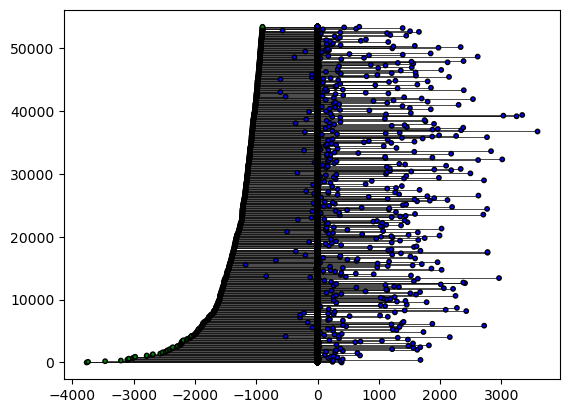

In [395]:
fig, ax = plt.subplots()


for i, row in tqdm(new_df.iterrows()):
    
    ax.plot([row['Repo_created_at'], row['Repo_updated_at']], [i, i], color='black', linewidth=0.5, zorder=1)
    ax.scatter([row['Repo_created_at'], row['Repo_updated_at']], [i, i], s=10, facecolors=['green', 'blue'], edgecolors='black', zorder=2)

ax.axvline(x=0, color='red', linestyle='--', linewidth=2.5, zorder=3)
       
pubdate_marker = plt.Line2D([0,0],[0,0],linestyle='--', color='red', label='PubDate', markerfacecolor='red', linewidth=3)
created_marker = plt.Line2D([0,0],[0,0],marker='o', color='w', label='Repo_created', markerfacecolor='green', markersize=8)
updated_marker = plt.Line2D([0,0],[0,0],marker='o', color='w', label='Repo_updated', markerfacecolor='blue', markersize=8)

ax.legend(handles=[pubdate_marker, created_marker, updated_marker])

plt.show()